# Anomaly detection in ECG signals using autoencoders

Autoencoders are neural networks trained to copy input to output. They encode data into a compressed representation and then decode it back. In this notebook, autoencoders are used to detect anomalies in ECG readings, showcasing a practical application of this technique. Let's get started!

In [81]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model

In [110]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.shape
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


The dataset has 140 columns which represent the ECG readings and a labels column which has been encoded to 0 or 1 showing whether the ECG is abnormal or normal.

In [83]:
#Now we will separate the data and labels so that it will be easy for us
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [84]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 0)

**Normalizing the data to the range [0-1]**

In [85]:
# We will use the formula (data - min)/(max - min)
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

#I have converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [86]:
#The labels are either 0 or 1, so convert them into boolean(true or false) 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Separate the data for normal ECG from that of abnormal ones

#Normal ECG data
n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

#Abnormal ECG data
an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

tf.Tensor(
[[0.2785218  0.18544017 0.20374465 ... 0.5284319  0.55826724 0.47603852]
 [0.6106017  0.523017   0.38420916 ... 0.5934708  0.56074226 0.6007342 ]
 [0.42402387 0.31254387 0.25355607 ... 0.41643447 0.45723966 0.40157694]
 ...
 [0.44934613 0.2930743  0.23919535 ... 0.51490444 0.5630568  0.44764975]
 [0.41676208 0.27271223 0.22704786 ... 0.60058016 0.6449843  0.51273775]
 [0.43035522 0.23275867 0.16943142 ... 0.5964163  0.6196378  0.44269276]], shape=(2333, 140), dtype=float32)


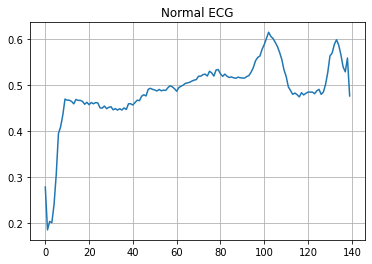

In [87]:
#Lets plot a normal ECG
plt.plot(np.arange(140), n_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

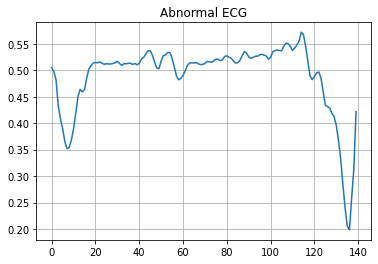

In [88]:
#Lets plot one from abnormal ECG
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

**So how will the model detect anomaly ?**

The model detects anomalies by using an autoencoder architecture. It is trained on normal ECG data to reconstruct the input. The discrepancy between original and reconstructed data is the "reconstruction error." During testing, if the error exceeds a predefined threshold, the input is classified as anomalous. This allows the model to identify anomalies by comparing the reconstruction error of abnormal ECG data to that of normal data. 

In [89]:
# Defining the model!
# The model has 2 parts : 1. Encoder and 2. Decoder
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [90]:
#Let's compile and train the model!!
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data)) #self supervised 

Epoch 1/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0459 - val_loss: 0.0448
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0440 - val_loss: 0.0423
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0415 - val_loss: 0.0399
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0392 - val_loss: 0.0377
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0370 - val_loss: 0.0354
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0347 - val_loss: 0.0332
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0326 - val_loss: 0.0312
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0307 - val_loss: 0.0294
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0280
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0277 - val_loss: 0.0268
Epoch 11/20
5/5 [=====================

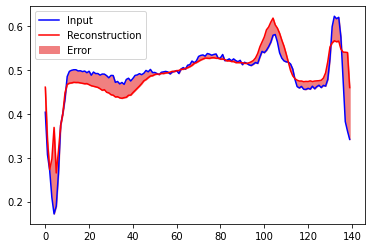

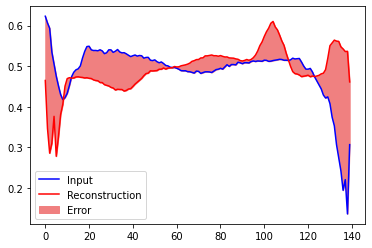

In [91]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

An ECG is anomalous if it's reconstruction error is greater than a threshold. 
Here the threshold is set to one standard deviation from the mean of normal training data.

In [92]:
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)

def prediction(model, data, threshold):
  rec = model(data)
  loss = losses.mae(rec, data)
  out=tf.math.less(loss, threshold)
  return out.numpy()
print(f'Threshold for this dataset is {threshold}')

Threshold for this dataset is 0.03217263147234917


In [116]:
pred_train = prediction(autoencoder, train_data, threshold)
cnt=0
for i in range(0,len(pred_train)):
    if(pred_train[i]==train_labels[i]):
        cnt+=1
accuracy=cnt*100/len(pred_train)
rounded_accuracy = format(accuracy, ".2f")  
print(f'Training accuracy is {rounded_accuracy} %')


Training accuracy is 94.00 %


In [118]:
pred_test = prediction(autoencoder, test_data, threshold)
cnt=0
for i in range(0,len(pred_test)):
    if(pred_test[i]==test_labels[i]):
        cnt+=1
accuracy=cnt*100/len(pred_test)
rounded_accuracy = format(accuracy, ".2f")  
print(f'Testing accuracy is {rounded_accuracy} %')

Testing accuracy is 93.80 %


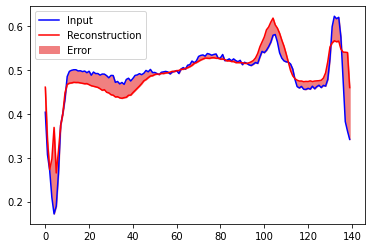

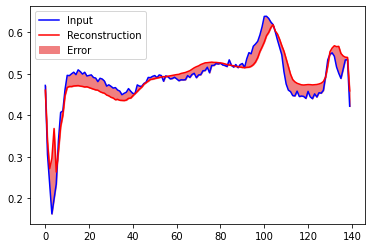

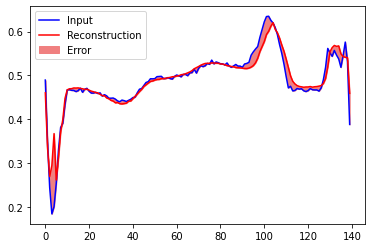

In [95]:
# Lets see some more result visually 
plot(n_test_data, 0)
plot(n_test_data, 1)
plot(n_test_data, 2)

The application of autoencoder-based models for anomaly detection can be expanded to numerous domains where identifying deviations from normal patterns is valuable such as Fraud Detection ,Cybersecurity, Predictive Maintenance etc